# Query for Spectraction Results in OGA

 work with Weakly_2022_39
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/10/31
- update : 2022/10/31


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/atmospec 	setup
drp_pipe              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/drp_pipe 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/eups 	setup
summit_utils          LOCAL:/home/d/dagoret/repos/repos_w_2022_39/summit_utils 	setup


In [2]:
! eups list -s lsst_distrib

   g0b29ad24fb+a10408d0bf 	current w_2022_39 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

## Give the collection

In [6]:
my_collection = "u/dagoret/spectro/noflat/empty~holo4/20220912"
datasetRefs = registry.queryDatasets(datasetType='spectraction', collections=my_collection, 
                                     where= "instrument='LATISS'")

In [7]:
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

In [8]:
## Config

In [9]:
# path index for each month
DATE="20220912"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"

## Loop on Exposure

In [10]:
all_ref_for_spectraction = []
all_dataId = []
all_spec = []
all_exposures = []

for i, ref in enumerate(datasetRefs):
    all_ref_for_spectraction.append(ref.dataId)
    print("======================== datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectraction', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    all_ref_for_spectraction.append(spec) 
    all_dataId.append( the_dataId) 
    all_spec.append(spec)
    all_exposures.append(the_exposure)
    if i > 5:
        break

======================== datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022091200106}
visit...................: 2022091200106
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20220912/20221026T100113Z
{'day_obs': 20220912, 'seq_num': 106, 'detector': 0}
======================== datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2022091200107}
visit...................: 2022091200107
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20220912/20221026T101538Z
{'day_obs': 20220912, 'seq_num': 107, 'detector': 0}
========================

## Plot

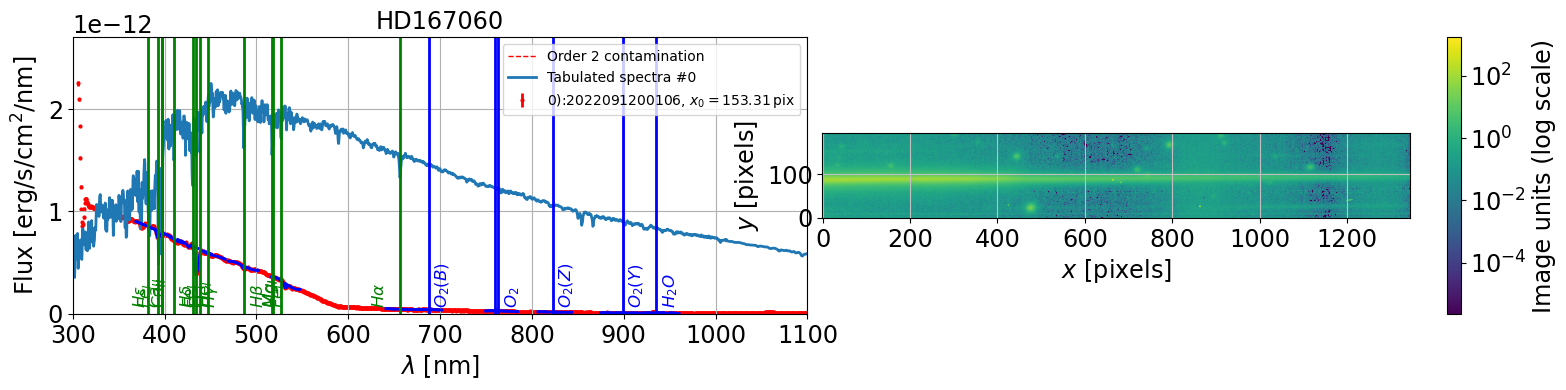

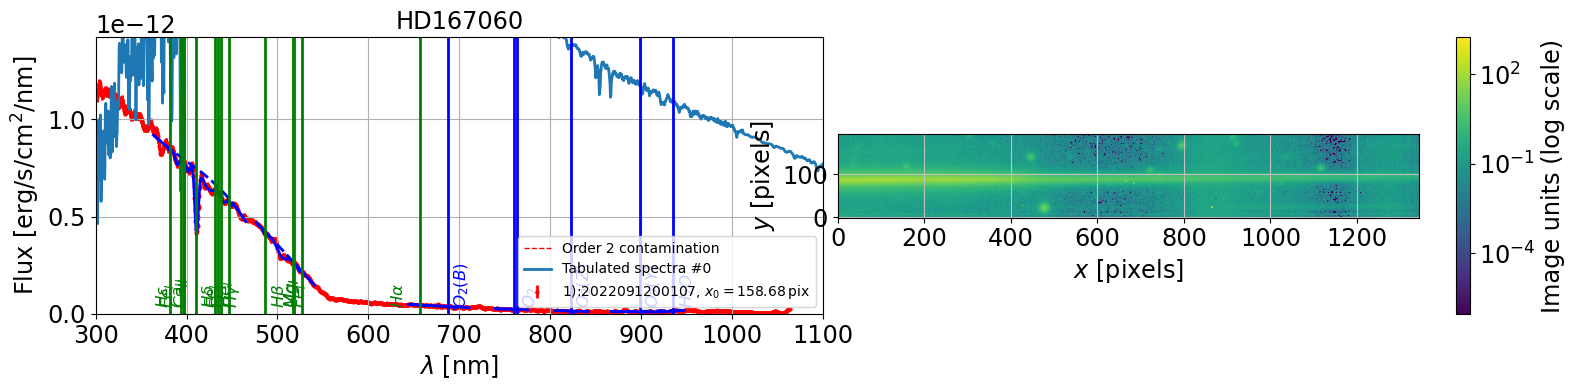

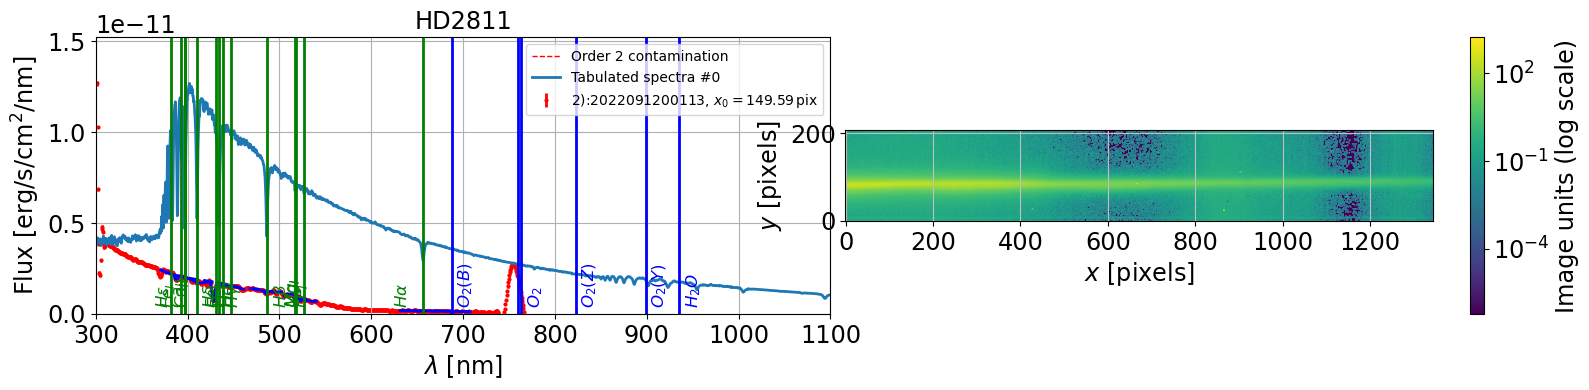

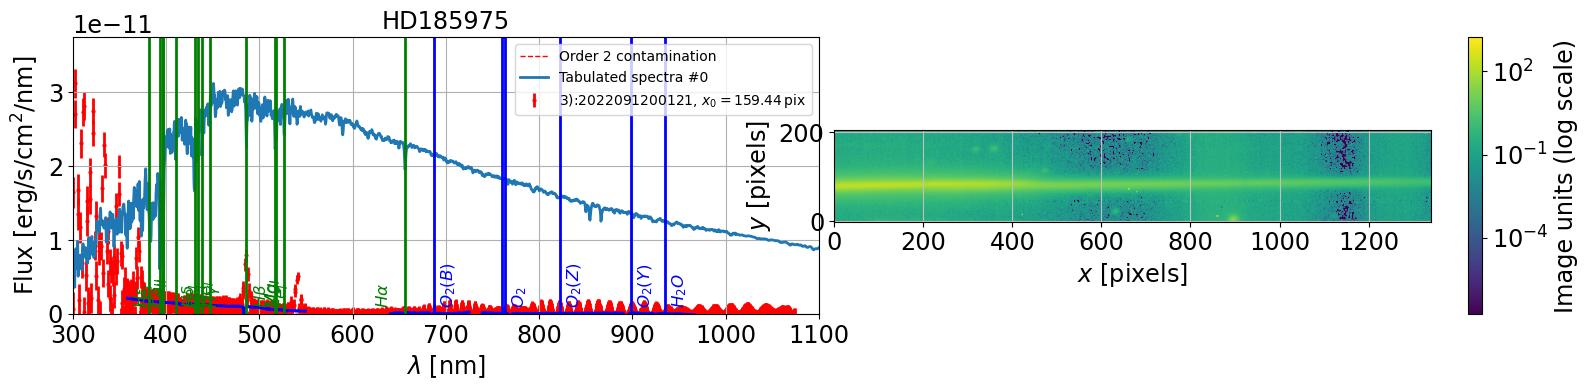

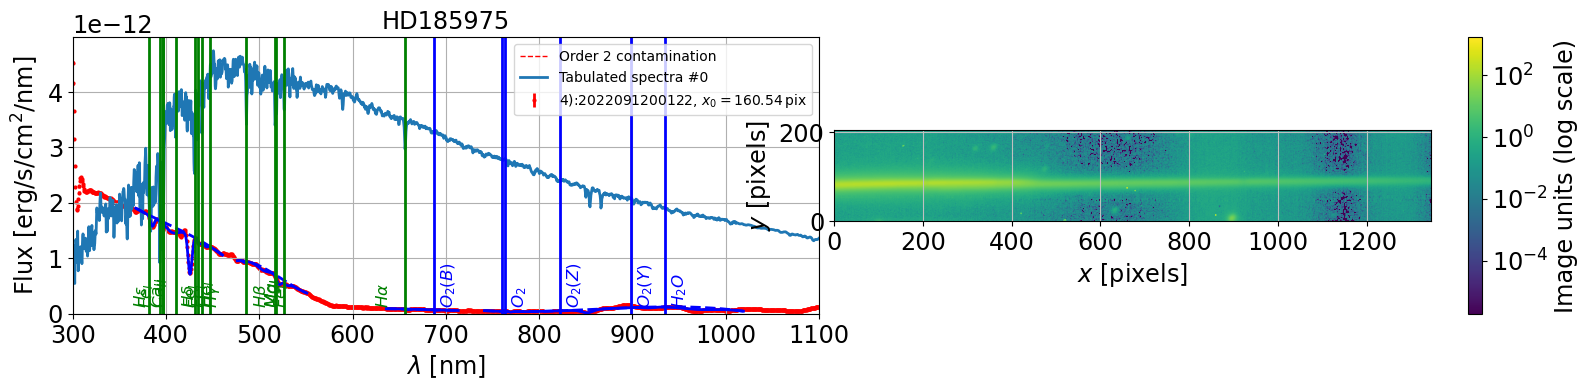

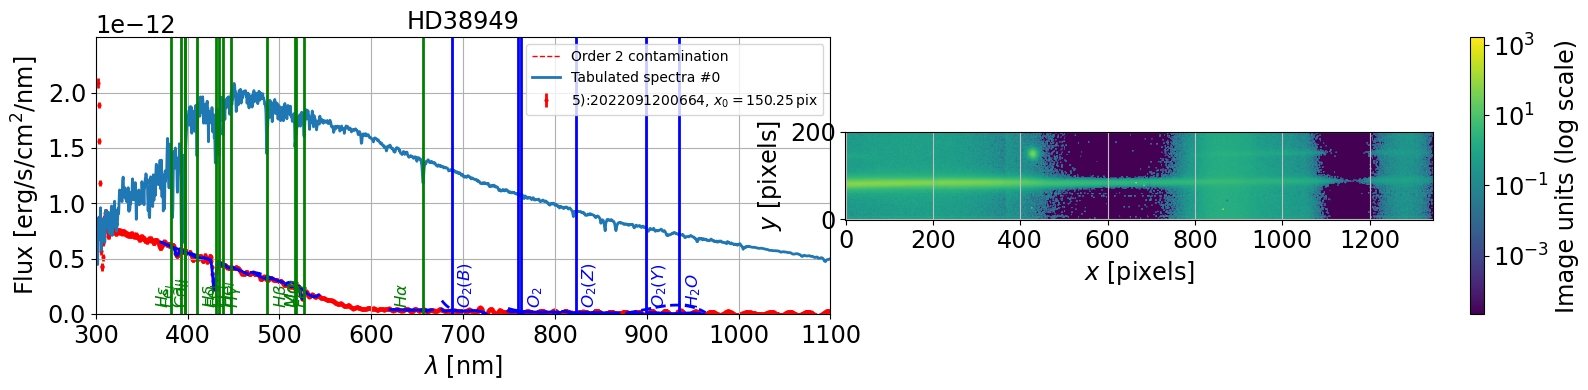

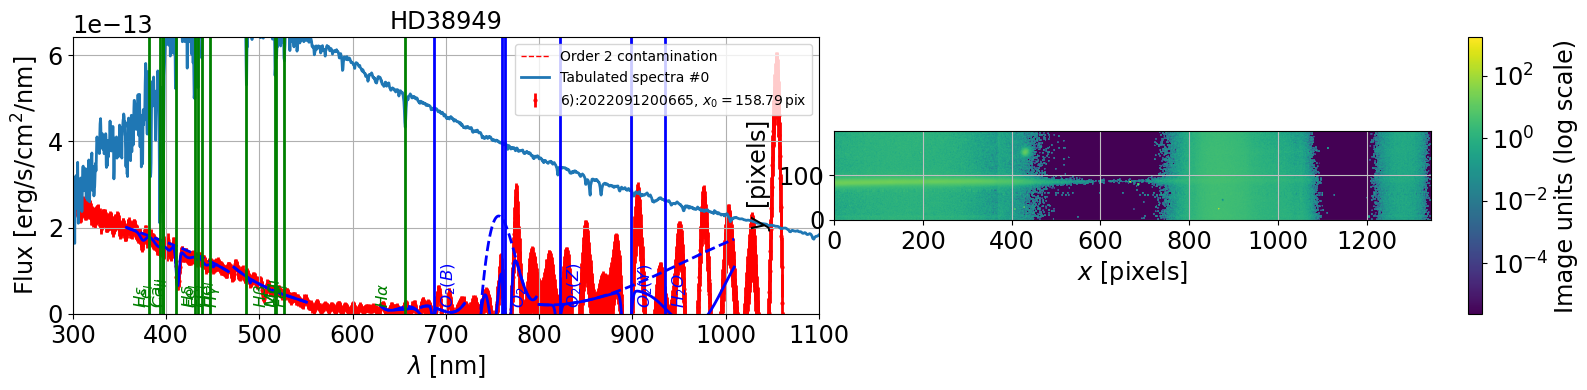

In [11]:
FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]



idx=0

for spec in all_spec:
    
    fig=plt.figure(figsize=(16,4))
    
    s=spec.spectrum
    label = str(idx) +"):" + str(all_exposures[idx])
    
    ax1 = fig.add_subplot(1, 2, 1)
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
        
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    idx+=1
    
 

In [12]:
infos

[[0, 'HD167060', '2022-09-13T01:21:26.405992547Z', 1.23373069063445, 0, 0, 0],
 [1, 'HD167060', '2022-09-13T01:22:09.211503001Z', 1.23459898457421, 0, 0, 0],
 [2, 'HD2811', '2022-09-13T01:26:05.830000089Z', 1.64107327445113, 0, 0, 0],
 [3, 'HD185975', '2022-09-13T01:30:53.808505359Z', 1.83763689501931, 0, 0, 0],
 [4, 'HD185975', '2022-09-13T01:31:36.699999655Z', 1.83759007842735, 0, 0, 0],
 [5, 'HD38949', '2022-09-13T07:20:48.532005656Z', 1.53029464277969, 0, 0, 0],
 [6, 'HD38949', '2022-09-13T07:21:31.436497321Z', 1.52558648716412, 0, 0, 0]]